In [7]:
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time

In [12]:
import numpy as np
import matplotlib.pyplot as plt

import math

'''
readSensorData - It will try to capture the range and angle data from the simulator.
                 The request for the range data is sent in streaming mode to force
                 it to sync with the angle data request which acts as a mutex.

inputs:
    -clientId: simulator client id obtained through a successfull connection with the simulator.
    -range_data_signal_id: string containing the range data signal pipe name.
    -angle_data_signal_id: string containing the angle data signal pipe name.
outputs:
    -returns None if no data is recovered.
    -returns two arrays, one with data range and the other with their angles, if data was 
    retrieved successfully.
'''
def readSensorData(clientId=-1, 
                    range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):

    # the first call should be non-blocking to avoid getting out-of-sync angle data
    returnCodeRanges, string_range_data = sim.simxGetStringSignal(clientId, range_data_signal_id, sim.simx_opmode_streaming)

    # the second call should block to avoid out-of-sync scenarios
    # between your python script and the simulator's main loop
    # (your script may be slower than the simulator's main loop, thus
    # slowing down data processing)
    returnCodeAngles, string_angle_data = sim.simxGetStringSignal(clientId, angle_data_signal_id, sim.simx_opmode_blocking)

    # check the if both data were obtained correctly
    if returnCodeRanges == 0 and returnCodeAngles == 0:
        # unpack data from range and sensor messages
        raw_range_data = sim.simxUnpackFloats(string_range_data)
        raw_angle_data = sim.simxUnpackFloats(string_angle_data)

        return raw_range_data, raw_angle_data

    # return none in case were nothing was gotten from the simulator
    return None


def draw_laser_data(laser_data, max_sensor_range=5):
    
    fig = plt.figure(figsize=(6,6), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
        
    for i in range(len(laser_data)):
        ang, dist = laser_data[i]
        
        # Quando o feixe não acerta nada, retorna o valor máximo (definido na simulação)
        # Logo, usar um pequeno limiar do máximo para considerar a leitura
        if (max_sensor_range - dist) > 0.1:
            x = dist * np.cos(ang)
            y = dist * np.sin(ang)
            c = 'r'
            if ang < 0:    
                c = 'b'
            ax.plot(x, y, 'o', color=c)

    ax.plot(0, 0, 'k>', markersize=10)
        
    ax.grid()
    ax.set_xlim([-max_sensor_range, max_sensor_range])
    ax.set_ylim([-max_sensor_range, max_sensor_range])

Program started
Connected to remote API server
[[-1.57079637  1.37725019]
 [-1.56785512  1.37862253]
 [-1.5648967   1.37458575]
 ...
 [ 1.5648967   4.9994998 ]
 [ 1.56785512  4.9994998 ]
 [ 1.57079637  4.9994998 ]]
Pos:  [-1.9695123434066772, -1.950817346572876, 0.13864518702030182]
Program ended


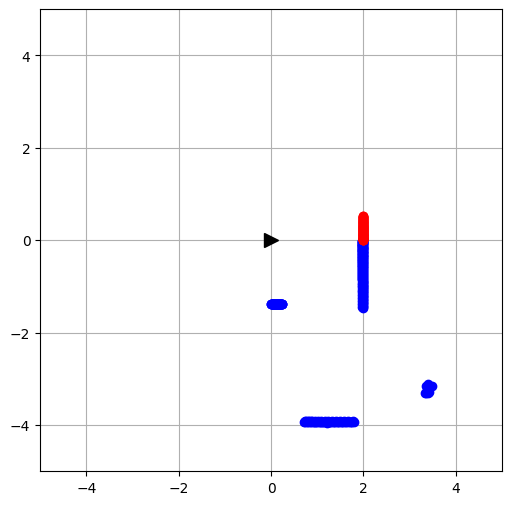

In [31]:
####################################################################################
#                                                                                  #
#                 LEMBRE-SE QUE A SIMULAÇÃO DEVE ESTAR EM EXECUÇÃO!                #
#                                                                                  #
####################################################################################

print ('Program started')
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if clientID!=-1:
    print ('Connected to remote API server')
    
    # Iniciando a simulação
    # Deve usar a porta do 'continuous remote API server services' (remoteApiConnections.txt)
    # e = sim.simxStartSimulation(clientID,sim.simx_opmode_blocking)

    # Handle para o ROBÔ    
    robotname = 'Pioneer_p3dx'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)     
    
    # Handle para as juntas das RODAS
    returnCode, l_wheel = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
    returnCode, r_wheel = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)    
    
    # Handle para os dados do LASER
    laser_range_data = "hokuyo_range_data"
    laser_angle_data = "hokuyo_angle_data"
    
    # Geralmente a primeira leitura é inválida (atenção ao Operation Mode)
    # Em loop até garantir que as leituras serão válidas
    returnCode = 1
    while returnCode != 0:
        returnCode, range_data = sim.simxGetStringSignal(clientID, laser_range_data, sim.simx_opmode_streaming + 10)
    
    # Prosseguindo com as leituras
    raw_range_data, raw_angle_data = readSensorData(clientID, laser_range_data, laser_angle_data)
    laser_data = np.array([raw_angle_data, raw_range_data]).T
    
    print(laser_data)
    draw_laser_data(laser_data)
    
    returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)        
    print('Pos: ', pos)
    
    #raise SystemExit()
    
    # Dados do Pioneer
    L = 0.381   # Metros
    r = 0.0975  # Metros

    t = 0
    # Lembrar de habilitar o 'Real-time mode'
    startTime=time.time()
    lastTime = startTime
    while t < 10:
        
        now = time.time()
        dt = now - lastTime
    
        # Fazendo leitura do laser   
        raw_range_data, raw_angle_data = readSensorData(clientID, laser_range_data, laser_angle_data)
        laser_data = np.array([raw_angle_data, raw_range_data]).T
        
        # Velocidade básica (linear, angular)
        v = .5
        w = np.deg2rad(0)      

        frente = int(len(laser_data)/2)
        lado_direito = int(len(laser_data)*1/4)
        lado_esquerdo = int(len(laser_data)*3/4)
        
        if laser_data[frente, 1] > 2:
            v = .5
            w = 0
        elif laser_data[lado_direito, 1] > 2:
            v = 0
            w = np.deg2rad(-30)
        elif laser_data[lado_esquerdo, 1] > 2:
            v = 0
            w = np.deg2rad(30)
        
        # Isso é o modelo cinemático, estudaremos detalhadamente depois!
        wl = v/r - (w*L)/(2*r)
        wr = v/r + (w*L)/(2*r)
        
        # Enviando velocidades
        sim.simxSetJointTargetVelocity(clientID, l_wheel, wl, sim.simx_opmode_streaming + 5)
        sim.simxSetJointTargetVelocity(clientID, r_wheel, wr, sim.simx_opmode_streaming + 5)        
    
        t = t + dt  
        lastTime = now

    # Parando o robô    
    sim.simxSetJointTargetVelocity(clientID, r_wheel, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, l_wheel, 0, sim.simx_opmode_oneshot_wait)        
       
    # Parando a simulação     
    sim.simxStopSimulation(clientID,sim.simx_opmode_blocking)         
        
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
else:
    print ('Failed connecting to remote API server')
    
print ('Program ended')